# Ukraine



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
# TODO: Put your dataset in your google drive!
os.chdir('/content/drive/MyDrive/TMD')
!ls

Mounted at /content/drive/
'Average score for each category.jpg'	  headlines.json   ru_w_sent.csv
'Average score for each emotion.jpg'	  news1.png	   ru_w_translation.csv
 en-articles.csv			  News_mask.png    sentiment.csv
 final_en.csv				  ru_policy.csv
'Frequency of entities in articles.jpg'   russia.png


In [ ]:
!ls

'Average score for each category.jpg'	  headlines.json   ru_w_sent.csv
'Average score for each emotion.jpg'	  news1.png	   ru_w_translation.csv
 en-articles.csv			  News_mask.png    sentiment.csv
 final_en.csv				  ru_policy.csv
'Frequency of entities in articles.jpg'   russia.png


## 1. Load data

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
nltk.download('punkt')
import time
import csv
from datetime import timedelta

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.7 MB/s 
     |████████████████████████████████| 596 kB 30.9 MB/s 
     |████████████████████████████████| 6.6 MB 18.7 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 880 kB 34.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=13ae5af973ca60b30eefbe3d2f30b519c5d62e038a2bcd9471d0083c79d260c0
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install bertopic

     |████████████████████████████████| 58 kB 3.1 MB/s 
     |████████████████████████████████| 636 kB 11.4 MB/s 
     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 5.2 MB 29.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 1.2 MB 11.5 MB/s 
     |████████████████████████████████| 1.1 MB 38.3 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330818 sha256=ca260b8fb609f275310920213bcaccbecc79af1348d807bb5e149163f1df953b
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=f3d1b3bdabace784c013ddf72f10b44833214b437bf35f6627c28834b988074d
  Stored in director

In [ ]:
ru_w_sent_path = "ru_w_sent.csv"
ru_w_translation_path = "ru_w_translation.csv"
en_path = 'final_en.csv'

In [ ]:
import json

In [ ]:
f = open('headlines.json')
data = json.load(f)
df_news = pd.DataFrame(data)

In [ ]:
ru_w_sent = pd.read_csv(ru_w_sent_path)
ru_w_translation = pd.read_csv(ru_w_translation_path)
en = pd.read_csv(en_path)

In [ ]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [ ]:
en = en.dropna()

In [ ]:
# fill na with description
ru_w_translation['translated'] = ru_w_translation['translated'].apply(cleanText)
en['text'] = en['text'].apply(cleanText)

In [ ]:
ru_w_translation['text_nopunc'] = [s.translate(str.maketrans('', '', string.punctuation)).replace('»', '').replace('«', '') for s in ru_w_translation['translated']]
en['text_nopunc'] = [s.translate(str.maketrans('', '', string.punctuation)).replace('»', '').replace('«', '') for s in en['text']]

In [ ]:
ru_w_translation['en_text_tokenized'] = [word_tokenize(t, language="english") for t in ru_w_translation['text_nopunc']]
en['en_text_tokenized'] = [word_tokenize(t, language="english") for t in en['text_nopunc']]

In [ ]:
snowball = SnowballStemmer(language="english")

In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

['Eighty', 'seven', 'miles', 'to', 'go', 'yet', 'Onward']

In [ ]:
df_news['title'] = df_news['title'].apply(cleanText)
df_news['title'] = [s.translate(str.maketrans('', '', string.punctuation)).replace('»', '').replace('«', '') for s in df_news['title']]

In [ ]:
df_news['title'] = [tokenizer.tokenize(t) for t in df_news['title']]
text_stemmed = []
for i in df_news['title']:
    text_stemmed.append([snowball.stem(w) for w in i if i])
df_news['title'] = text_stemmed

In [ ]:
text_stemmed = []
for i in ru_w_translation['en_text_tokenized']:
    text_stemmed.append([snowball.stem(w) for w in i if i])

text_stemmed_en = []
for i in en['en_text_tokenized']:
    text_stemmed_en.append([snowball.stem(w) for w in i if i])

In [ ]:
ru_w_translation['text_stemmed'] = text_stemmed
en['text_stemmed'] = text_stemmed_en

In [ ]:
from collections import Counter

In [ ]:
import itertools
a = en['text_stemmed'].values
a_joined= list(itertools.chain.from_iterable(a))

In [ ]:
Counter(a_joined).most_common(10)

[('the', 150687),
 ('to', 75243),
 ('of', 70314),
 ('and', 61493),
 ('in', 58114),
 ('a', 56677),
 ('’', 36563),
 ('that', 32125),
 ('“', 29225),
 ('”', 29012)]

In [ ]:
my_stopwords = stopwords.words("english") +  ['ukrain', 'russia', 'said', 'would', 'state', 'also', 'advertis', 'countri', 'one']

In [ ]:
vals = [i for i in a_joined if i not in my_stopwords]

In [ ]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

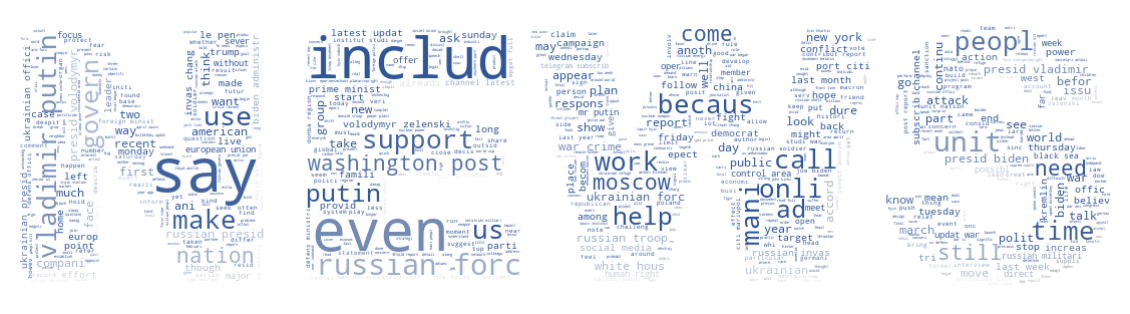

In [ ]:
mask = np.array(Image.open("News_mask.png"))
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(' '.join(vals))
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("news1.png", format="png") 
plt.show()

## Topic modelling

In [ ]:
from bertopic import BERTopic

In [ ]:
topic_model = BERTopic(
                 top_n_words = 20,
                 nr_topics = 8,
                 n_gram_range = (1, 2),
                 min_topic_size = 30,
                 verbose=True)

In [ ]:
stemmed_clean = []
for i in ru_w_translation['text_stemmed']:
  stemmed_clean.append([w for w in i if w not in my_stopwords])

In [ ]:
stemmed_clean_en = []
for i in en['text_stemmed']:
  stemmed_clean_en.append([w for w in i if w not in my_stopwords])

In [ ]:
stemmed_joined = []
for i in stemmed_clean:
  stemmed_joined.append(' '.join([w for w in i]))

stemmed_joined_en = []
for i in stemmed_clean_en:
  stemmed_joined_en.append(' '.join([w for w in i]))

In [ ]:
stemmed_joined = []
for i in df_news['title']:
  stemmed_joined.append(' '.join([w for w in i if i not in my_stopwords]))

In [ ]:
ru_w_translation['stemmed_joined'] = stemmed_joined
en['stemmed_joined'] = stemmed_joined_en

In [ ]:
en = en.reset_index()

In [ ]:
topics = topic_model.fit_transform(stemmed_joined)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

2022-05-06 00:26:42,634 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-05-06 00:27:27,093 - BERTopic - Reduced dimensionality
2022-05-06 00:27:27,370 - BERTopic - Clustered reduced embeddings
2022-05-06 00:27:28,549 - BERTopic - Reduced number of topics from 20 to 9


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,2286,-1_to_in_the_of
1,0,716,0_trump_the_to_republican
2,1,667,1_the_season_seri_of
3,2,554,2_covid_vaccin_covid19_omicron
4,3,554,3_to_the_of_in
5,4,441,4_ukrain_russia_russian_to
6,5,347,5_in_shoot_after_woman
7,6,280,6_china_chines_to_peng
8,7,157,7_hack_appl_spywar_to


In [ ]:
topic_model.get_topic(0)

[('trump', 0.04934432232823598),
 ('the', 0.03683071549492143),
 ('to', 0.034605445122487755),
 ('republican', 0.022693117071506532),
 ('gop', 0.02201136329592366),
 ('of', 0.021343829144856215),
 ('vote', 0.021275864828935086),
 ('elect', 0.019454378717024143),
 ('in', 0.019262476713510644),
 ('say', 0.018491028661903997),
 ('jan', 0.017851688510196268),
 ('for', 0.01779063090327328),
 ('and', 0.017699348779905984),
 ('democrat', 0.017545550696401836),
 ('is', 0.016506501586711166),
 ('on', 0.013969822770167919),
 ('are', 0.013904193708300813),
 ('biden', 0.013628994147827355),
 ('hous', 0.013295947808542622),
 ('he', 0.01281806380745286)]

In [ ]:
topic_model.get_topic(1)

[('the', 0.049750140255329596),
 ('season', 0.0373595072624774),
 ('seri', 0.031883161352635046),
 ('of', 0.02758515784535131),
 ('netfli', 0.024250326038207343),
 ('to', 0.02315925983125018),
 ('on', 0.021076666824124884),
 ('in', 0.02038019441985739),
 ('and', 0.02020261142170191),
 ('tv', 0.018796911567029024),
 ('star', 0.017021039685423716),
 ('for', 0.016958943325439905),
 ('show', 0.01636062099829329),
 ('is', 0.015214570285792046),
 ('trailer', 0.015016742557312555),
 ('hbo', 0.014523237340584746),
 ('at', 0.013799670412017333),
 ('with', 0.01311102338200339),
 ('disney', 0.011618589872467796),
 ('offici', 0.011244480756016893)]

In [ ]:
topic_model.get_topic(2)

[('covid', 0.056317890491778363),
 ('vaccin', 0.052731165946562276),
 ('covid19', 0.04032221873236175),
 ('omicron', 0.03648206904753987),
 ('variant', 0.035598507421684036),
 ('to', 0.03051957849923957),
 ('of', 0.026715589088576568),
 ('new', 0.026083882044764115),
 ('in', 0.026009212203915524),
 ('for', 0.021295354209885688),
 ('case', 0.020707658904525278),
 ('the', 0.019627544981015495),
 ('and', 0.01743470659113152),
 ('say', 0.017239665817993202),
 ('mandat', 0.014489644841971705),
 ('from', 0.014272018967963523),
 ('test', 0.013873202816836738),
 ('africa', 0.013488377481609488),
 ('on', 0.012687395892585544),
 ('as', 0.012436406321397257)]

In [ ]:
topic_model.get_topic(3)

[('to', 0.034700949328610724),
 ('the', 0.03241171832422365),
 ('of', 0.028751123219123768),
 ('in', 0.028328020556177398),
 ('and', 0.02052028444065243),
 ('for', 0.016489361120813218),
 ('tesla', 0.015725768521275156),
 ('space', 0.015332624308243276),
 ('it', 0.013569900799618898),
 ('oil', 0.013476480568783452),
 ('is', 0.012863529012336382),
 ('on', 0.012678791768263892),
 ('car', 0.012213130492697347),
 ('power', 0.01217101234758329),
 ('as', 0.011836164199002842),
 ('first', 0.011597986547126102),
 ('with', 0.010938381311884618),
 ('from', 0.010846421691078021),
 ('climat', 0.010840090808126979),
 ('nasa', 0.010562707127455726)]

In [ ]:
topic_model.get_topic(4)

[('ukrain', 0.08965211751643594),
 ('russia', 0.07579358046394641),
 ('russian', 0.052488685413082416),
 ('to', 0.04516851813327199),
 ('us', 0.03179238475759232),
 ('putin', 0.028697706947039357),
 ('troop', 0.0278343546186627),
 ('say', 0.026659899045757704),
 ('of', 0.023606126331972326),
 ('in', 0.021166348342574064),
 ('nato', 0.020622325037092964),
 ('and', 0.01970320709828768),
 ('invad', 0.018868764587543156),
 ('warn', 0.018781294011843086),
 ('border', 0.0179360668418996),
 ('on', 0.01738261780569377),
 ('if', 0.016975571352960215),
 ('invas', 0.016461640226466265),
 ('the', 0.01631847079038824),
 ('as', 0.015512271091901968)]

In [ ]:
topic_model.get_topic(5)

[('in', 0.04985939359365351),
 ('shoot', 0.03559201474660844),
 ('after', 0.02944938069018864),
 ('woman', 0.02926982205393364),
 ('school', 0.028190541107949916),
 ('man', 0.025767218551376633),
 ('to', 0.02503683214179893),
 ('arrest', 0.02458665052530426),
 ('of', 0.02408927926218836),
 ('for', 0.023814085545678817),
 ('polic', 0.02327504469339731),
 ('kill', 0.023067965276062283),
 ('suspect', 0.022408847104854773),
 ('charg', 0.021876978592794222),
 ('shot', 0.019084032064035736),
 ('her', 0.01771754686451627),
 ('and', 0.017058166286073338),
 ('school shoot', 0.016668209886137642),
 ('michigan', 0.016329634291764487),
 ('rape', 0.015649232862940964)]

In [ ]:
topic_model.get_topic(6)

[('china', 0.08334946461540622),
 ('chines', 0.04421491574955513),
 ('to', 0.04018008458827721),
 ('peng', 0.03445244073706167),
 ('shuai', 0.032965441130979906),
 ('peng shuai', 0.032965441130979906),
 ('taiwan', 0.03207448326257504),
 ('olymp', 0.030837644370004677),
 ('japan', 0.028510651788955597),
 ('us', 0.0281138199898307),
 ('tenni', 0.027632719572755277),
 ('of', 0.02491943353335455),
 ('in', 0.023719437282000207),
 ('say', 0.01840266367156407),
 ('for', 0.01712232864999868),
 ('tenni star', 0.016183443348605265),
 ('on', 0.016012655151463495),
 ('the', 0.01504938087225765),
 ('after', 0.014856539549455863),
 ('star', 0.014725500830265931)]

In [ ]:
topic_model.get_topic(7)

[('hack', 0.040943166612864526),
 ('appl', 0.029286744544693075),
 ('spywar', 0.026571815518203614),
 ('to', 0.025690170969711303),
 ('the', 0.02495664975458227),
 ('nso', 0.024800361150323372),
 ('million', 0.023894516403200217),
 ('of', 0.023476612471846594),
 ('crypto', 0.02281949400849191),
 ('for', 0.022467377095701183),
 ('hacker', 0.021925882231780415),
 ('in', 0.020581929902330185),
 ('user', 0.02057133619226486),
 ('group', 0.0199571133504354),
 ('us', 0.018765417040042455),
 ('data', 0.018481426713042617),
 ('iphon', 0.01819582890034687),
 ('attack', 0.017882218918234532),
 ('microsoft', 0.017772841865387932),
 ('with', 0.017103237461192834)]

(-0.5, 2499.5, 1799.5, -0.5)

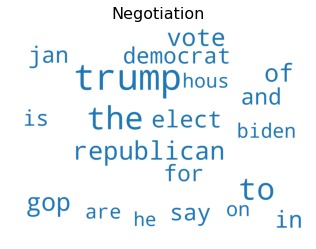

In [ ]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  mode="RGBA",
                  prefer_horizontal=1.0, 
                  stopwords=my_stopwords)

topics = topic_model.get_topic(0)

topic_words = dict(topics)
cloud.generate_from_frequencies(topic_words, max_font_size=300)
plt.gca().imshow(cloud.recolor(color_func=lambda **kwargs: '#1f77b4'))
plt.gca().set_title('Negotiation', fontdict=dict(size=16))
plt.gca().axis('off')

(-0.5, 2499.5, 1799.5, -0.5)

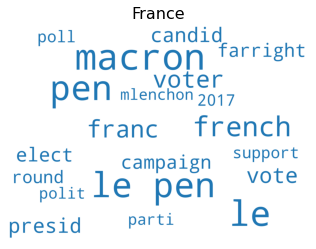

In [ ]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  mode="RGBA",
                  prefer_horizontal=1.0)

topics = topic_model.get_topic(1)

topic_words = dict(topics)
cloud.generate_from_frequencies(topic_words, max_font_size=300)
plt.gca().imshow(cloud.recolor(color_func=lambda **kwargs: "#1f77b4"))
plt.gca().set_title('France', fontdict=dict(size=16))
plt.gca().axis('off')

(-0.5, 2499.5, 1799.5, -0.5)

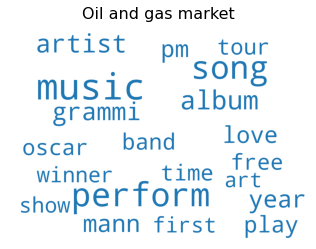

In [ ]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  mode="RGBA",
                  prefer_horizontal=1.0)

topics = topic_model.get_topic(2)

topic_words = dict(topics)
cloud.generate_from_frequencies(topic_words, max_font_size=300)
plt.gca().imshow(cloud.recolor(color_func=lambda **kwargs: "#1f77b4"))
plt.gca().set_title('Oil and gas market', fontdict=dict(size=16))
plt.gca().axis('off')

(-0.5, 2499.5, 1799.5, -0.5)

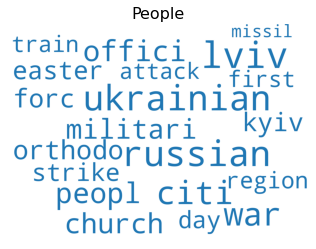

In [ ]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  mode="RGBA",
                  prefer_horizontal=1.0)

topics = topic_model.get_topic(3)

topic_words = dict(topics)
cloud.generate_from_frequencies(topic_words, max_font_size=300)
plt.gca().imshow(cloud.recolor(color_func=lambda **kwargs: "#1f77b4"))
plt.gca().set_title('People', fontdict=dict(size=16))
plt.gca().axis('off')

(-0.5, 2499.5, 1799.5, -0.5)

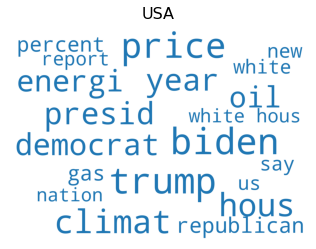

In [ ]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  mode="RGBA",
                  prefer_horizontal=1.0)

topics = topic_model.get_topic(4)

topic_words = dict(topics)
cloud.generate_from_frequencies(topic_words, max_font_size=300)
plt.gca().imshow(cloud.recolor(color_func=lambda **kwargs: "#1f77b4"))
plt.gca().set_title('USA', fontdict=dict(size=16))
plt.gca().axis('off')

(-0.5, 2499.5, 1799.5, -0.5)

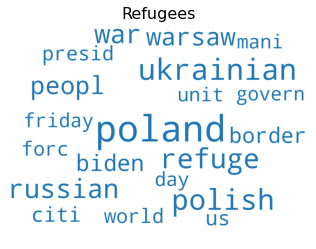

In [ ]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  mode="RGBA",
                  prefer_horizontal=1.0)

topics = topic_model.get_topic(5)

topic_words = dict(topics)
cloud.generate_from_frequencies(topic_words, max_font_size=300)
plt.gca().imshow(cloud.recolor(color_func=lambda **kwargs: "#1f77b4"))
plt.gca().set_title('Refugees', fontdict=dict(size=16))
plt.gca().axis('off')

(-0.5, 2499.5, 1799.5, -0.5)

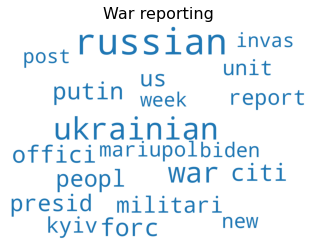

In [ ]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  mode="RGBA",
                  prefer_horizontal=1.0)

topics = topic_model.get_topic(6)

topic_words = dict(topics)
cloud.generate_from_frequencies(topic_words, max_font_size=300)
plt.gca().imshow(cloud.recolor(color_func=lambda **kwargs: "#1f77b4"))
plt.gca().set_title('War reporting', fontdict=dict(size=16))
plt.gca().axis('off')

## Policy-DistilBERT

[link](https://huggingface.co/MoritzLaurer/policy-distilbert-7d)
This model will classify articles into 7 categories.
Maximium words are 512.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
# use cuda
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:

model_name = "MoritzLaurer/policy-distilbert-7d"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model = model.to(device)
label_names = ["external relations", "freedom and democracy", "political system", "economy", "welfare and quality of life", "fabric of society", "social groups"]
# the output corresponds to the following labels:
# 0: external relations, 1: freedom and democracy, 2: political system, 3: economy, 4: welfare and quality of life, 5: fabric of society, 6: social groups

def get_prediction(model, input):
    output = model(input)
    # output to dictionary
    prediction = torch.softmax(output["logits"][0], -1).tolist()
    # prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
    return prediction

Downloading:   0%|          | 0.00/258 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/948 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [ ]:
# prepare data
ru_policy = ru_w_translation['translated'].apply(tokenizer, truncation=True, return_tensors="pt")
ru_policy = ru_policy.tolist()
ru_policy = [x["input_ids"].to(device) for x in ru_policy]

In [ ]:
# infor about dataset
print("English policy dataset:")
print(len(ru_policy))
print("Example input:", ru_policy[0])
print("cuda:", ru_policy[0].is_cuda)
print("Example output:", get_prediction(model, ru_policy[0]))

English policy dataset:
1522
Example input: tensor([[  101,  5924,  1010,  2006,  1996,  3978,  1997,  1996,  9560,  1997,
          1996,  2569,  3169,  1010,  2323,  2468,  1037,  1000,  3671, 20065,
          1000,  1997,  3607,  1012,  1999,  2019,  4357,  2007, 15544,  2050,
         24576, 21756,  1010,  3580,  1011,  2343,  2061, 26493, 28640, 22141,
         19960,  7178,  6777,  1010, 13233,  2008,  1996,  2569,  3169,  1999,
          5924,  2001,  4975,  2429,  2000,  2933,  1012,  1999,  2010,  3193,
          1010,  5924,  2323,  2036,  2468,  1037, 27668, 27606, 18425,  2110,
          2008,  2052, 17738, 17457,  3424,  1011,  2845,  3343,  1012, 23564,
         26876,  3217,  2061, 26493, 28640,  7383,  2008,  1996,  2569,  3169,
          2018,  5625,  3952,  2138,  1996, 11100,  2008,  3607,  2018,  2275,
          2005,  2993,  2018,  2025,  2042,  4719,  2083, 17610,  1012,  1000,
          2122, 11100, 14396,  2000,  1996,  2925,  1997,  5924,  1517,  1996,
        

In [ ]:
# calculate the results!
ru_policy_res = []
start_time = time.time()
for i in range(len(ru_policy)):
    prediction = get_prediction(model, ru_policy[i])
    ru_policy_res.append(prediction)
    if i % 100 == 0 and i:
        elapsed_time = time.time() - start_time
        estimated_time = elapsed_time * (len(ru_policy) - i) / i
        print("Completed {} rows, estimate left time: {}".format(i, timedelta(seconds=estimated_time)))


Completed 100 rows, estimate left time: 0:00:23.619546
Completed 200 rows, estimate left time: 0:00:22.522598
Completed 300 rows, estimate left time: 0:00:18.743249
Completed 400 rows, estimate left time: 0:00:14.950566
Completed 500 rows, estimate left time: 0:00:12.355175
Completed 600 rows, estimate left time: 0:00:10.395314
Completed 700 rows, estimate left time: 0:00:08.818463
Completed 800 rows, estimate left time: 0:00:07.422187
Completed 900 rows, estimate left time: 0:00:06.181741
Completed 1000 rows, estimate left time: 0:00:05.036428
Completed 1100 rows, estimate left time: 0:00:03.978537
Completed 1200 rows, estimate left time: 0:00:02.973508
Completed 1300 rows, estimate left time: 0:00:02.014554
Completed 1400 rows, estimate left time: 0:00:01.090366
Completed 1500 rows, estimate left time: 0:00:00.202873


In [ ]:
# save file
import csv
with open('ru_policy.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(label_names)
    write.writerows(ru_policy_res)

### Basic analysis about policy categories

In [ ]:
# lets do some basic analysis
policy = np.array(ru_policy_res)
print(policy.shape)

(1522, 7)


Average score for each category
external relations  :  0.7500748793447168
freedom and democracy  :  0.14114939008012856
political system  :  0.018825399458259902
economy  :  0.04771994775145149
welfare and quality of life  :  0.00858139072656512
fabric of society  :  0.026921870871414188
social groups  :  0.00672711843592976


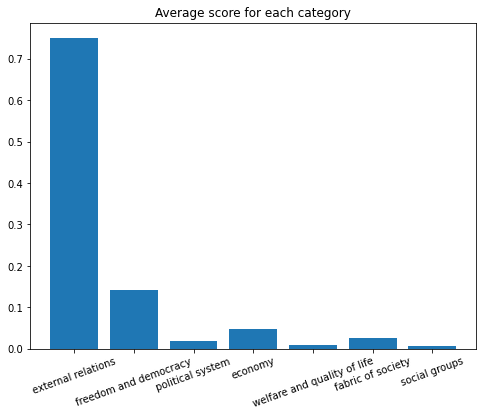

In [ ]:
avg_policy = np.average(policy, axis=0)
# print(avg_policy)
title = "Average score for each category"
print(title)
for i in range(7):
    print(label_names[i], " : ", avg_policy[i])

plt.figure(figsize=(8,6))
plt.bar(np.arange(7), avg_policy)
plt.title(title)
plt.xticks(ticks=np.arange(7), labels=label_names, rotation = 20)
plt.savefig(title+".jpg")
plt.show()


## Sentiment Analysis in English

[link](https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis)


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!pip3 install emoji

     |████████████████████████████████| 175 kB 5.0 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=eaeec4e6e46bd637937cc2fbc3629b4e69ce8a631d6447417f6fabfe010c76ba
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
model = model.to(device)
label_names = ["Neg", "Neu", "Pos"]
def get_prediction(model, input):
    output = model(input)
    # output to dictionary
    prediction = torch.softmax(output["logits"][0], -1).tolist()
    # prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
    return prediction

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

In [ ]:
# prepare data
ru_senti = ru_w_translation['translated'].apply(tokenizer, truncation=True, return_tensors="pt")
ru_senti = ru_senti.tolist()
ru_senti = [x["input_ids"].to(device) for x in ru_senti]
print(ru_senti[0])

tensor([[    0,  5378,  1127,  3800,     7,    24,     6,  5746,    15,     6,
          9587,    15,     6,   985, 18190,  4359,     7,   151,   870,    11,
         61933,  1826, 61583,    26,    15,   855, 20841, 58557,    16,    74,
          2029,    30,  8822,  1469,  4139,  8688,     7, 39565,  1652,  2266,
           717,  1132,  3614,   541, 10809,  2694,  8496, 28272,  2426,     7,
          5647,    25,     6,   985,  8069,    16,  5378, 43755,    38,  9100,
          3479,     9, 12489,     4,    16,    91, 23778,     7,  5378, 43755,
           151,   237,   870,    11,  6862,  1370, 22581,  3789,   852,    25,
            86,  7427, 15806,  3617, 19640, 28444,   460,     4, 45356, 39104,
          2266,   717,  1132,  3614, 30062,    25,     6,   985,  8069,   118,
         11079, 11791,   153,     6, 37312,    25, 41324,   118,   610,    19,
          2570,   118,    46,   108,  8726,   292, 60547,  7794,   460,     4,
         61933,   198, 37312,  6506,     9,     6,  

In [ ]:
# calculate the results!
ru_senti_res = []
start_time = time.time()
for i in range(len(ru_senti)):
    prediction = get_prediction(model, ru_senti[i])
    ru_senti_res.append(prediction)
    if i % 100 == 0 and i:
        elapsed_time = time.time() - start_time
        estimated_time = elapsed_time * (len(ru_senti) - i) / i
        print("Completed {} rows, estimate left time: {}".format(i, timedelta(seconds=estimated_time)))


Completed 100 rows, estimate left time: 0:00:30.656735
Completed 200 rows, estimate left time: 0:00:24.422520
Completed 300 rows, estimate left time: 0:00:19.918828
Completed 400 rows, estimate left time: 0:00:17.081778
Completed 500 rows, estimate left time: 0:00:14.895756
Completed 600 rows, estimate left time: 0:00:13.088743
Completed 700 rows, estimate left time: 0:00:11.969940
Completed 800 rows, estimate left time: 0:00:10.935664
Completed 900 rows, estimate left time: 0:00:09.612477
Completed 1000 rows, estimate left time: 0:00:08.295115
Completed 1100 rows, estimate left time: 0:00:06.572980
Completed 1200 rows, estimate left time: 0:00:04.911521
Completed 1300 rows, estimate left time: 0:00:03.324894
Completed 1400 rows, estimate left time: 0:00:01.802203
Completed 1500 rows, estimate left time: 0:00:00.320625


In [ ]:
# save file
import csv
with open('sentiment.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(label_names)
    write.writerows(ru_senti_res)

In [ ]:
old_list = list(ru_w_sent['sentiment'])

In [ ]:
hist_arr = [i.index(max(i)) for i in ru_senti_res]

In [ ]:
new_arr = np.array([hist_arr.count(0) / len(hist_arr), hist_arr.count(1) / len(hist_arr), hist_arr.count(2) / len(hist_arr)])

In [ ]:
old_arr = np.array([old_list.count('NEGATIVE') / len(old_list), old_list.count('NEUTRAL') / len(old_list), old_list.count('POSITIVE') / len(old_list)])

Average score for each emotion
Neg  :  0.6695137976346912
Neu  :  0.3291721419185282
Pos  :  0.001314060446780552


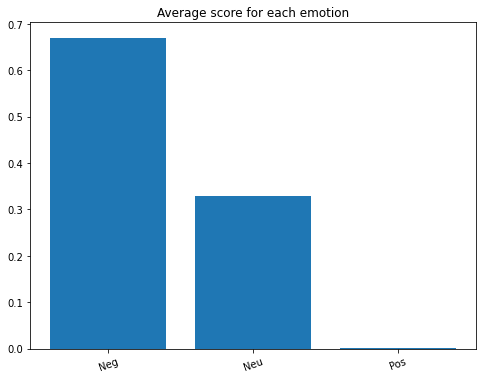

In [ ]:
label_names = ["Neg", "Neu", "Pos"]
title = "Average score for each emotion"
print(title)
for i in range(len(old_arr)):
    print(label_names[i], " : ", old_arr[i])

plt.figure(figsize=(8,6))
plt.bar(np.arange(len(old_arr)), old_arr)
plt.title(title)
plt.xticks(ticks=np.arange(len(old_arr)), labels=label_names, rotation = 20)
plt.savefig(title+".jpg")
plt.show()

Average score for each emotion
Neg  :  0.1583442838370565
Neu  :  0.8324572930354797
Pos  :  0.009198423127463863


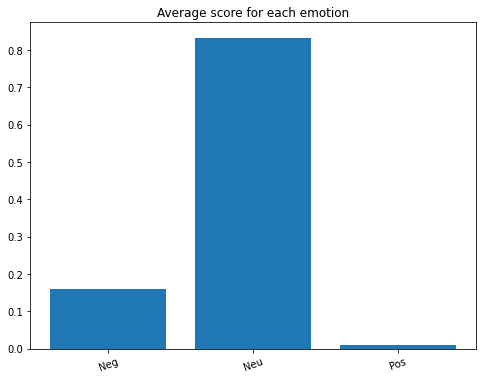

In [ ]:
label_names = ["Neg", "Neu", "Pos"]
title = "Average score for each emotion"
print(title)
for i in range(len(new_arr)):
    print(label_names[i], " : ", new_arr[i])

plt.figure(figsize=(8,6))
plt.bar(np.arange(len(new_arr)), new_arr)
plt.title(title)
plt.xticks(ticks=np.arange(len(new_arr)), labels=label_names, rotation = 20)
plt.savefig(title+".jpg")
plt.show()



(1522, 3)
Average score for each emotion
Neg  :  0.18623184245170013
Neu  :  0.7842651534539191
Pos  :  0.029503004248504883


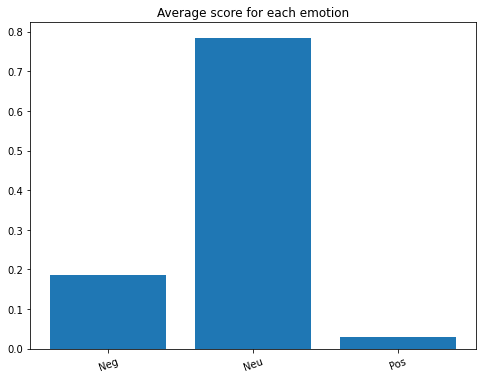

In [ ]:
# lets do some basic analysis
senti = np.array(ru_senti_res)
print(senti.shape)

avg_senti = np.average(senti, axis=0)
# print(avg_senti)
title = "Average score for each emotion"
print(title)
for i in range(len(avg_senti)):
    print(label_names[i], " : ", avg_senti[i])

plt.figure(figsize=(8,6))
plt.bar(np.arange(len(avg_senti)), avg_senti)
plt.title(title)
plt.xticks(ticks=np.arange(len(avg_senti)), labels=label_names, rotation = 20)
plt.savefig(title+".jpg")
plt.show()



## model fine-tuned from roberta-large for NER task

[link](https://huggingface.co/Jean-Baptiste/roberta-large-ner-english)

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
# model = model.to(device)
label_names = ["PER", "ORG", "LOC", "MISC"]
label_indexes = {"PER": 0, "ORG": 1, "LOC": 2, "MISC": 3}

nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0)
print(nlp)
def get_prediction(text):
    res = nlp(text)
    # [index, score, word]
    res = [[label_indexes[d["entity_group"]], d["score"], d["word"]] for d in res]
    return res

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/849 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

In [ ]:
# calculate the results!
ru_ner_res = []
start_time = time.time()
for i in range(len(ru_w_translation['translated'])):
    prediction = get_prediction(ru_w_translation['translated'][i])
    ru_ner_res.append(prediction)
    if i % 100 == 0 and i:
        elapsed_time = time.time() - start_time
        estimated_time = elapsed_time * (len(ru_w_translation['translated']) - i) / i
        print("Completed {} rows, estimate left time: {}".format(i, timedelta(seconds=estimated_time)))

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


Completed 100 rows, estimate left time: 0:01:26.245548
Completed 200 rows, estimate left time: 0:01:20.470006
Completed 300 rows, estimate left time: 0:01:12.828087
Completed 400 rows, estimate left time: 0:01:05.546851
Completed 500 rows, estimate left time: 0:00:58.990622
Completed 600 rows, estimate left time: 0:00:53.154499
Completed 700 rows, estimate left time: 0:00:47.514600
Completed 800 rows, estimate left time: 0:00:41.519773
Completed 900 rows, estimate left time: 0:00:35.742563
Completed 1000 rows, estimate left time: 0:00:29.933554
Completed 1100 rows, estimate left time: 0:00:24.246678
Completed 1200 rows, estimate left time: 0:00:18.470181
Completed 1300 rows, estimate left time: 0:00:12.734099
Completed 1400 rows, estimate left time: 0:00:06.995985
Completed 1500 rows, estimate left time: 0:00:01.255838


In [ ]:
# [index, score, word]
# only preserve the top score of words?

# let's do some basic analysis of these words

# show the score range
scores = [ column[1] for row in ru_ner_res for column in row ]
scores = np.array(scores)
print("Score range is [{} , {}]".format(np.min(scores), np.max(scores)))

Score range is [0.30040621757507324 , 0.9999699592590332]


In [ ]:
# use score as the currency of some word
words = {}
for row in ru_ner_res:
    for entity in row:
        # [index, score, word]
        index, score, word = entity
        words[word] = words.get(word, 0) + score
words = {k: v for k, v in sorted(words.items(), key=lambda item: -item[1])}
print(words)

{' ukraine': 3243.4846256375313, ' russian': 2183.385178923607, ' russia': 1457.1661851406097, ' ukrainian': 1063.7720537781715, ' kiev': 591.2317975759506, '.': 434.5812065601349, ' united states': 433.36520552635193, ' tass': 352.9209280014038, ' moscow': 303.1576465368271, ' vladimir putin': 267.9370880126953, ' ria novosti': 228.87610334157944, ' nato': 217.69685912132263, ' german': 209.29106038808823, ' germany': 206.64065325260162, ' vladimir zelensky': 189.96943998336792, ' ministry of defence': 174.4887980222702, ' american': 169.82176810503006, ' us': 167.8598299920559, ' eu': 146.17307597398758, ' washington': 136.2391459941864, ' joe biden': 132.9473830461502, ' donbass': 129.94782441854477, ' turkey': 127.96549344062805, ' european union': 123.80480313301086, ' poland': 121.98686361312866, ' british': 120.94264489412308, ' istanbul': 113.75072288513184, ' united nations': 113.14206182956696, ' kremlin': 110.97158688306808, ' donetsk': 110.72316408157349, ' u.s.': 110.70269

In [ ]:
key_words = list(words.keys())
delete_words = ['.', ' u]
for d in delete_words:
    key_words.remove(d)
print(key_words[:50])

ValueError: ignored

In [ ]:
key_words = list(words.keys())

In [ ]:
after_words = {k: v for k, v in words.items() if k in key_words[:50]}
print(after_words)

{' ukraine': 3243.4846256375313, ' russian': 2183.385178923607, ' russia': 1457.1661851406097, ' ukrainian': 1063.7720537781715, ' kiev': 591.2317975759506, '.': 434.5812065601349, ' united states': 433.36520552635193, ' tass': 352.9209280014038, ' moscow': 303.1576465368271, ' vladimir putin': 267.9370880126953, ' ria novosti': 228.87610334157944, ' nato': 217.69685912132263, ' german': 209.29106038808823, ' germany': 206.64065325260162, ' vladimir zelensky': 189.96943998336792, ' ministry of defence': 174.4887980222702, ' american': 169.82176810503006, ' us': 167.8598299920559, ' eu': 146.17307597398758, ' washington': 136.2391459941864, ' joe biden': 132.9473830461502, ' donbass': 129.94782441854477, ' turkey': 127.96549344062805, ' european union': 123.80480313301086, ' poland': 121.98686361312866, ' british': 120.94264489412308, ' istanbul': 113.75072288513184, ' united nations': 113.14206182956696, ' kremlin': 110.97158688306808, ' donetsk': 110.72316408157349, ' u.s.': 110.70269

Frequency of entities in articles


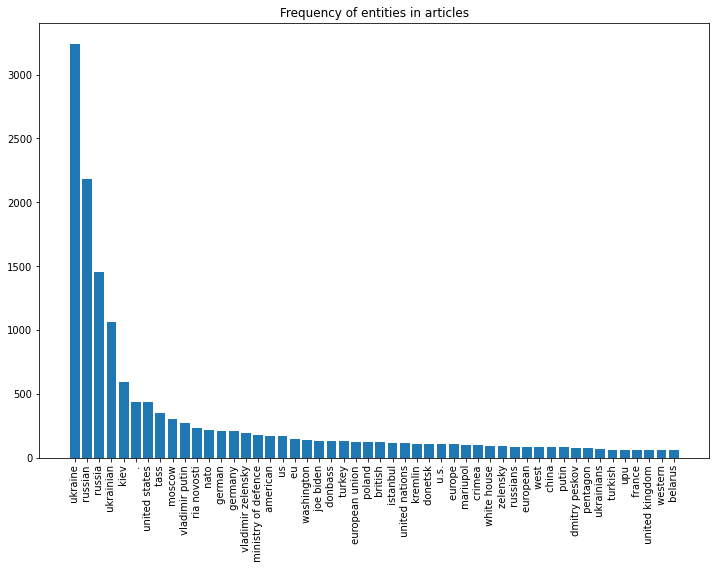

In [ ]:
# lets do some basic analysis

top50 = key_words[:50]
top50_scores = [words[word] for word in top50]

title = "Frequency of entities in articles"
print(title)

plt.figure(figsize=(12,8))
plt.bar(np.arange(50), top50_scores)
plt.title(title)
plt.xticks(ticks=np.arange(50), labels=top50, rotation = 90)
plt.savefig(title+".jpg")
plt.show()